# Part 0: Initialising

In [12]:
# Initializing
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
from scipy.stats import bootstrap
import statsmodels.api as sm
import statsmodels.formula.api as smf

params = {
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.usetex": False,
}

mpl.rcParams.update(params)

import warnings
warnings.filterwarnings("ignore")

To start with, we will import three datasets that are available on YouNiverse:

``df_timeseries_en.tsv.gz``  
``df_channels_en.tsv.gz``  
``yt_metadata_helper.feather``

In [2]:
df_time_series = pd.read_csv(
    "./data/df_timeseries_en.tsv.gz", compression="infer", sep="\t"
)
df_time_series["datetime"] = pd.to_datetime(df_time_series["datetime"])
# round the total number of subscribers, it is easier to consider 1 person and instead half of a person...
df_time_series.subs = df_time_series.subs.round(0)

df_channels = pd.read_csv("./data/df_channels_en.tsv.gz", compression="infer", sep="\t")
df_channels["join_date"] = pd.to_datetime(df_channels["join_date"])

In [3]:
video_metadatas = pd.read_feather(
    "./data/yt_metadata_helper.feather",
    columns=[
        "categories",
        "upload_date",
        "duration",
        "like_count",
        "dislike_count",
        "view_count",
        "channel_id",
    ],
)

In [4]:
df_time_series.head(2)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03,202494.555556,0.000000,650.0,0.000000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10,394085.666667,191591.111111,1046.0,395.777778,6,1,1


In [5]:
df_channels.head(2)

,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087


In [6]:
video_metadatas.head(2)

,categories,upload_date,duration,like_count,dislike_count,view_count,channel_id
0,Film & Animation,2016-09-28,1159,8.0,1.0,1057.0,UCzWrhkg9eK5I8Bm3HfV-unA
1,Film & Animation,2016-09-28,2681,23.0,1.0,12894.0,UCzWrhkg9eK5I8Bm3HfV-unA


# Part 1: Initial Analysis and Data Visualization

In this section, we will analyze the YouNiverse data to determine the potential factors that could lead to success on Youtube. This initial analysis will help us narrow down to a subset of the dataset to focus on for Milestone 3 analysis.

## Question 1: How is the weekly content creation pattern of Youtubers regarding the upload frequency, video lengths, upload time?

### Section 1: Video Upload Frequency

In this section, we will mainly consider the weekly video upload frequency. To do that, we will first group the `video_metadatas` by upload week for all channels, to have an idea on the upload trend. We will not use `df_time_series` for the purpose of this section, which has ready-to-use weekly information regarding each channel, as it only considers the data from 2015-01-05 to 2019-10-06.

In [28]:
video_count = (
    video_metadatas.groupby(pd.Grouper(key="upload_date", freq="W")).count().channel_id
)

Text(0.5, 1.0, 'Number of videos uploaded each week')

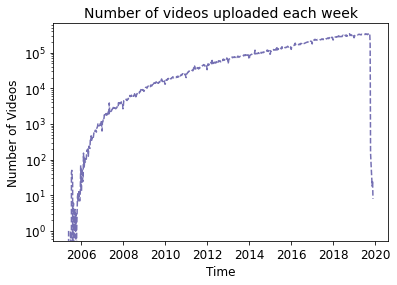

In [29]:
plt.plot(video_count, color="#7570b3", ls="--", label="\% videos uploaded")
plt.yscale("log")
plt.ylabel("Number of Videos")
plt.xlabel("Time")
plt.title("Number of videos uploaded each week")

From the graph above, we can see that the number of videos being uploaded to YouTube has increased steadily. Now let's have a closer look at the number of videos uploaded by each channel. Here we will consider the number of videos uploaded by each channel per year, as this is a preliminary analysis.

In [33]:
# The following graph shows how many videos each channel uploads to YouTube per year.
video_metadatas["yearNumber"] = video_metadatas["upload_date"].dt.year
vd_cnt_by_id_yr = (
    video_metadatas.groupby(["channel_id", "yearNumber"])
    .count()
    .categories.unstack()
    .reset_index()
)
vd_cnt_by_id_yr.columns.name = None
vd_cnt_by_id_yr_summary = vd_cnt_by_id_yr.describe()

Text(0.5, 1.0, 'The 2nd and 3rd quartiles of yearly video upload frequency')

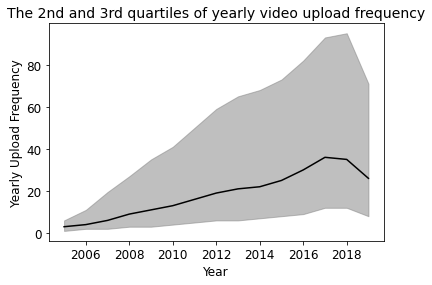

In [34]:
plt.fill_between(
    x=list(vd_cnt_by_id_yr_summary.columns.values),
    y1=list(vd_cnt_by_id_yr_summary.loc["25%", :]),
    y2=list(vd_cnt_by_id_yr_summary.loc["75%", :]),
    alpha=0.5,
    color="gray",
)
plt.plot(vd_cnt_by_id_yr_summary.loc["50%", :], color="black")
plt.xlabel("Year")
plt.ylabel("Yearly Upload Frequency")
plt.title("The 2nd and 3rd quartiles of yearly video upload frequency")
# here we choose quartiles, since the mean would be significantly affected by extremely high yearly upload rates


This graphs shows that YouTubers uploads more videos every year with time, and the variation of upload frequency between channels also increased significantly since the beginning of the study period.

### Section 2: Video Lengths

Firstly, we will take a look at the basic statistics of video lengths using `video_metadatas` . To make it easier to understand, we will first convert the duration into minutes for the subsequent analysis.

In [7]:
# divide the video duration by 60 to convert duration to minutes
video_metadatas["duration_min"] = video_metadatas["duration"] / 60
video_metadatas.duration_min.describe()

count    7.292479e+07
mean     1.262794e+01
std      3.033518e+01
min      1.666667e-02
25%      2.233333e+00
50%      4.733333e+00
75%      1.163333e+01
max      6.002617e+03
Name: duration_min, dtype: float64

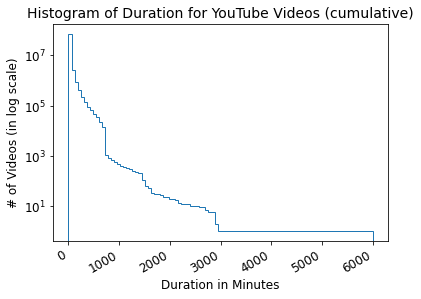

In [10]:
duration_min_cumul = plt.hist(
    video_metadatas.duration_min, bins=100, log=True, cumulative=-1, histtype="step"
)
plt.title("Histogram of Duration for YouTube Videos (cumulative)")
plt.ylabel("# of Videos (in log scale)")
plt.xlabel("Duration in Minutes")
plt.xticks(rotation=30, ha="right")
plt.show()

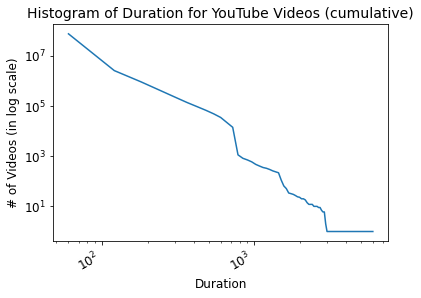

In [13]:
plt.loglog(duration_min_cumul[1][1:], duration_min_cumul[0])
plt.title("Histogram of Duration for YouTube Videos (cumulative)")
plt.ylabel("# of Videos (in log scale)")
plt.xlabel("Duration")
plt.xticks(rotation=30, ha="right")
plt.show()

From the basic statistics and histogram, we can observe a significant difference in mean (12.63 minutes) and median (4.73 minutes), and the max duration (100 hours) is much higher then both mean and median. The distribution of the duration resembles that of heavy tail distribution. This observation suggests that there are extremely long videos in the dataset that would increase the mean significantly. Therefore, quartiles are better to represent the dataset without considering outliers.

Therefore, we will have a look at the quartiles of duration of videos in the dataset to have a better idea about the distribution: 

Text(0.5, 1.0, 'Duration of Videos in Minutes')

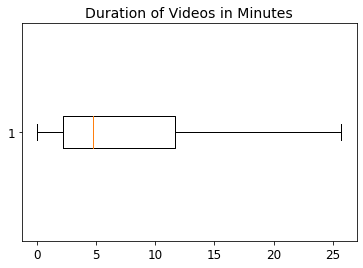

In [11]:
plt.boxplot(video_metadatas["duration_min"], showfliers=False, vert=False)
plt.title("Duration of Videos in Minutes")

TO-DO: GET AVERAGE VIDEO LENGTH PER YOUTUBER

### Section 3: Upload Time
In this section, we want to investigate when the YouTubers upload videos during the week.

In [35]:
video_metadatas["weekNumber"] = video_metadatas["upload_date"].dt.weekday
vd_cnt_by_id_wk = (
    video_metadatas.groupby(["channel_id", "weekNumber", "yearNumber"])
    .count()
    .categories.unstack()
    .reset_index()
)
vd_cnt_by_id_wk.columns.name = None
vd_cnt_by_id_wk["mean_upload"] = vd_cnt_by_id_wk.iloc[:, 2:].mean(axis=1, skipna=True)

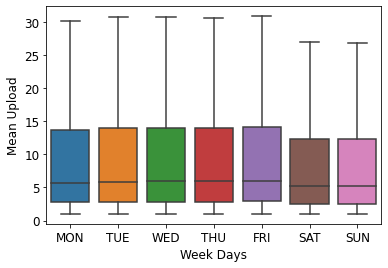

In [36]:
labels = ["MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"]
ax = sns.boxplot(
    x="weekNumber", y="mean_upload", data=vd_cnt_by_id_wk, showfliers=False
).set(
    xlabel='Week Days', 
    ylabel='Mean Upload',
    xticklabels= labels)

This boxplot shows that the variation between upload rate during weekdays are not significantly different. However, during the weekend, it seems that mean upload rate is less than during the week. Let's try to visualize it better by counting the total number of videos uploaded each day of the week, regardless the channel ID:

In [37]:
vd_cnt_by_wk = (
    video_metadatas.groupby(["weekNumber", "yearNumber"])
    .count()
    .categories.unstack()
    .reset_index()
)
vd_cnt_by_wk.columns.name = None


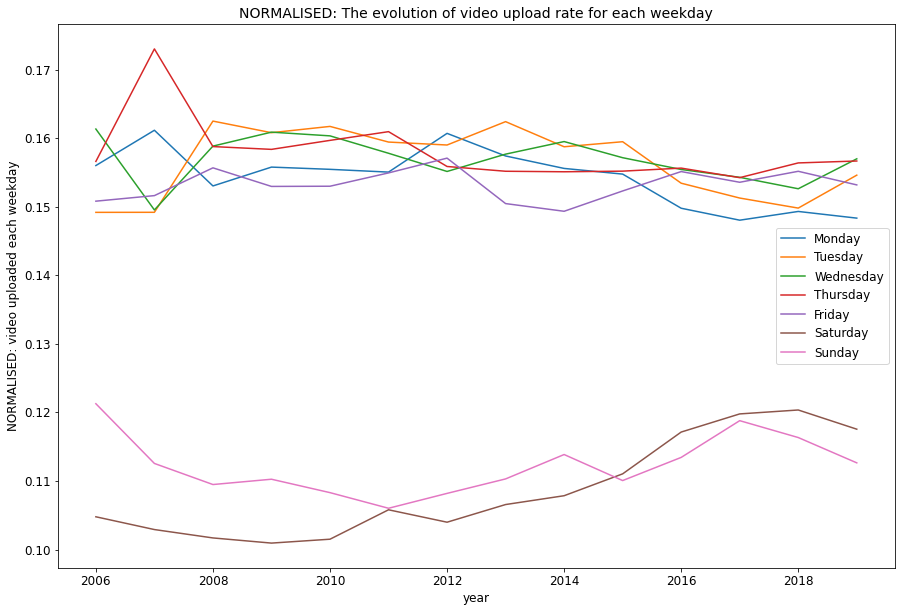

In [38]:
vd_cnt_by_wk_norm = vd_cnt_by_wk.iloc[:, 2:] / vd_cnt_by_wk.iloc[:, 2:].sum(skipna=True)
plt.rcParams["figure.figsize"] = (15, 10)
plt.plot(vd_cnt_by_wk_norm.T)
plt.legend(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
plt.xlabel("year")
plt.ylabel("NORMALISED: video uploaded each weekday")
plt.title("NORMALISED: The evolution of video upload rate for each weekday")
plt.show()

This graph suggests that the number of video uploaded from Monday to Friday is not significantly different from each other throughout the study period. Generally speaking, YouTubers upload more during weekdays than during the weekends. However, we can also observe an increasing number of videos uploaded on Saturdays.

## Question 2: How are the subscription patterns for reaching key numbers of subscribers, aka, 1k, 10k, 100k, 1M?

In this section, we will investigate the time frame for YouTubers to reach key milestones in their channel success - number of subscriptions.

In [ ]:
def get_df_channel_ascension(start_subs, end_subs):
    """finds the channels in the time series that have less than the start_subs and more than end_subs.
    It means that it begins with less than start_subs and have now at least end_subs

    Args:
        start_subs (float): low_threshold
        end_subs (float): high_threshold

    Returns:
        dataframe containing all the channels with evolution from starts_subs to end_subs
    """
    under_start_subs = df_time_series[df_time_series["subs"] < start_subs]
    more_end_subs = df_time_series[df_time_series["subs"] > end_subs]
    channel_start_to_end = df_time_series[
        df_time_series.channel.isin(under_start_subs.channel)
        & df_time_series.channel.isin(more_end_subs.channel)
    ]
    return channel_start_to_end

In [ ]:
def get_mean_time_to_reach_X_subs(df, lower_bound, upper_bound):
    time_to_reach_X_subs = df.groupby("channel").apply(
        lambda group: pd.Series(
            {
                "from_zero_to_hero_duration": group[group.subs > upper_bound][
                    "datetime"
                ].iloc[0]
                - group[group.subs < lower_bound]["datetime"].iloc[-1]
            }
        )
    )
    return time_to_reach_X_subs

In [ ]:
channel_10K_to_1M = get_df_channel_ascension(10_000, 1_000_000)
print(
    "We have {} channels that begins with 10K subs and reach at least 1M".format(
        channel_10K_to_1M.channel.nunique()
    )
)

In [ ]:
first_channel = channel_10K_to_1M.iloc[0]
test = channel_10K_to_1M[channel_10K_to_1M["channel"] == first_channel.channel]
# test = test[(test['datetime'] > np.datetime64('2018-07-20')) & (test['datetime'] < np.datetime64('2019-01-20'))]
test.plot(x="datetime", y="subs")
print("There are {} weeks for this channel".format(test.shape[0]))
print(
    "We should have approximately the same value : \n{} and {}".format(
        7 * test.shape[0], test.iloc[-1].datetime - test.iloc[0].datetime
    )
)

In [ ]:
# get the time it takes to go from less than 10K to 1M
time_to_reach_1M = get_mean_time_to_reach_X_subs(channel_10K_to_1M, 10_000, 1_000_000)
time_to_reach_1M.head()

In [ ]:
print(
    "In average YTbers take {} days to reach 1M of subscribers".format(
        time_to_reach_1M["from_zero_to_hero_duration"].mean().days
    )
)

We will then bootstrap this result for Milestone 3 to see the time it takes to reach 1M subscribers and its confidence interval.

In [ ]:
data = time_to_reach_1M["from_zero_to_hero_duration"].apply(
    lambda delta_time: delta_time.days
)

In [ ]:
rng = np.random.default_rng()
conf_interval_reach_1M = bootstrap(
    (data,),
    np.mean,
    confidence_level=0.95,
    random_state=rng,
).confidence_interval
conf_interval_reach_1M

print(
    "The 95% interval of confidence, the time taken to reach 1M (from 10K) is [{}, {}]".format(
        conf_interval_reach_1M.low, conf_interval_reach_1M.high
    )
)

## Question 3: Which categories are more popular during the study period? Which types of videos receive more positive feedback?

In this question, we will use `video_metadatas` to determine the which categories are more popular and with good review. This will help us to decide three categories to look deeper into for Milestone 3.

### Section 1: Number of Views

In [ ]:
#  make a copy of the video_metadatas
videos_with_cat = video_metadatas[:]
# here I tried to use the same expression as the replace you used below but it doesnt seem to work...
videos_with_cat["categories"] = videos_with_cat["categories"].apply(
    lambda x: x.replace(" & ", "_")
)
# delete the rows with empty categories
videos_with_cat.categories.replace("", np.nan, inplace=True)
videos_with_cat.dropna(subset=["categories"], inplace=True)

In [ ]:
encoded_cat = pd.get_dummies(videos_with_cat.categories)
video_metadatas_encoded = videos_with_cat.join(encoded_cat)
video_metadatas_encoded["year"] = video_metadatas_encoded["upload_date"].dt.year


In [ ]:
mean_views = video_metadatas_encoded.groupby(["year", "categories"]).apply(
    lambda x: pd.Series({"mean_view": x.view_count.mean()})
)


In [ ]:
# see the top most viewed categories every year
largest_cat_every_year = (
    mean_views.groupby("year")["mean_view"].nlargest(2).droplevel(0)
)
largest_cat_every_year[:30]

In [ ]:
# the following to determine which type of videos are more popular
# now we will determine how many videos are uploaded to YouTube by each channel by year
video_count_by_year = (
    videos_with_cat.dropna(axis=0).groupby(["categories", "yearNumber"]).sum()
)
# NOTE THAT CATEGORIES::MOVIES AND SHOWS HAVE VERY FEW DATA!

In [ ]:
video_view_count_by_year = video_count_by_year.view_count.unstack().reset_index()
video_view_count_by_year.columns.name = None

In [ ]:
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_view_count_by_year.shape[0]):
    plt.plot(
        video_view_count_by_year.loc[
            i,
        ][2:],
        label=video_view_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("video view count")
plt.title("video view counts per year for each category")
plt.show()


In [ ]:
# NORMALISATION:
## 1. view count - normalise wrt. total video views per year, to see which categories is viewed more every year
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_view_count_by_year.shape[0]):
    plt.plot(
        video_view_count_by_year.loc[
            i,
        ][2:]
        / video_view_count_by_year.sum(axis=0)[2:],
        label=video_view_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("NORMALISED: video view count")
plt.title("NORMALISED: video view counts per year for each category")
plt.show()
# view on music videos decreases, whereas on entertainment and gaming increases


### Section 2: Number of Likes

In [ ]:
video_like_count_by_year = video_count_by_year.like_count.unstack().reset_index()
video_like_count_by_year.columns.name = None

In [ ]:
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_like_count_by_year.shape[0]):
    plt.plot(
        video_like_count_by_year.loc[
            i,
        ][2:],
        label=video_like_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("video likes count")
plt.title("video likes counts per year for each category")
plt.show()

In [ ]:
## 2. like count - normalise wrt. total likes+dislikes for that category for that year
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_like_count_by_year.shape[0]):
    plt.plot(
        video_like_count_by_year.loc[
            i,
        ][2:]
        / (
            video_like_count_by_year.loc[
                i,
            ][2:]
            + video_dislike_count_by_year.loc[
                i,
            ][2:]
        ),
        label=video_like_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("NORMALISED: video likes count")
plt.title("NORMALISED: likes per counts per year for each category")
plt.show()

# now it is interesting to see that news_politics and education are consistantly less liked
# whereas for nonprofits_activism is becoming more loved

In [ ]:
## 3. like count versus view count - normalise wrt. total like counts over view counts for each category for each year
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_like_count_by_year.shape[0]):
    plt.plot(
        video_like_count_by_year.loc[
            i,
        ][2:]
        / (
            video_view_count_by_year.loc[
                i][2:]
        ),
        label=video_like_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("NORMALISED: like over views")
plt.title("NORMALISED: video like counts over view counts per category per year")
plt.show()


### Section 3: Number of Dislikes

In [ ]:
video_dislike_count_by_year = video_count_by_year.dislike_count.unstack().reset_index()
video_dislike_count_by_year.columns.name = None

In [ ]:
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_dislike_count_by_year.shape[0]):
    plt.plot(
        video_dislike_count_by_year.loc[
            i,
        ][2:],
        label=video_dislike_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("video dislikes count")
plt.title("video dislikes counts per year for each category")
plt.show()


TO-DO: CHANGE THE LEGEND ORDER BY THE ORDER IN 2005